# Week 4 Assignment

In this assignment, I am looking at a Kaggle challenge to predict whether tweets are about real disasters or not. We would need to do some Natural Language Processing (NLP) to understand the tweets, before feeding it into a Recurent Neural Network (RNN) model. Specifically I will be looking at GRU (Gated Recurrent Unit) and LTSM.

I will start by importing the necessary libraries we will need for the assignment.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, LSTM, Bidirectional

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

As I'm using Google Colab, I need to mount my drive to import my datafiles.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Understanding the data**

Now, I will want to find out more about the training and test dataset, such as the structure and dimension of the data.

In [3]:
df_train = pd.read_csv('/content/drive/MyDrive/DTSA5511/Week 4/train.csv')
df_train.shape

(7613, 5)

In [4]:
df_test = pd.read_csv('/content/drive/MyDrive/DTSA5511/Week 4/test.csv')
df_test.shape

(3263, 4)

In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


For the training data, there are 7,613 tweets, and we can see the 5 columns of the data are id, keyword, location, text and target, where target=1 means the tweet is about real disasters, and target=0 means otherwise.

**Exploratory Data Analysis**

Let's see if we have a balanced dataset with sufficient positive and negative sample tweets that we can use for training

In [6]:
traintarget_counts = df_train['target'].value_counts()
traintarget_counts

,count
target,
0,4342
1,3271


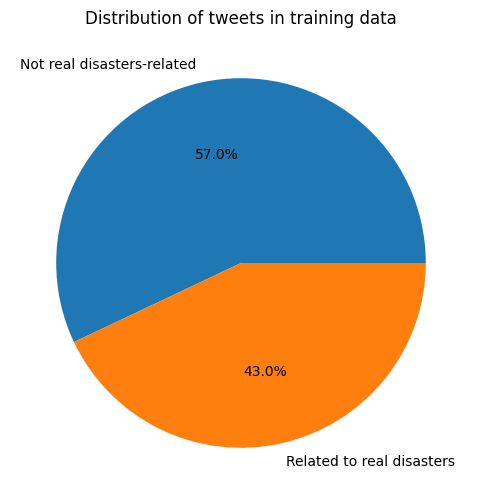

In [7]:
counts = [4342, 3271]
labels = ["Not real disasters-related", "Related to real disasters"]

plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%')
plt.title("Distribution of tweets in training data")
plt.show()

Out of the 7,613 tweets, there are 3,271 tweets (43%) that are identified to be about real disasters, and the remaining 4,342 are not (57%). While we do not have equal positive and negative samples, I think this data is still sufficient for our training, since we still have about more than 40% of the data as positive samples.

I also want to take a look at the top keywords that are in the tweets that are categorised to be about real disasters, which include words like "derailment" and "outbreak".

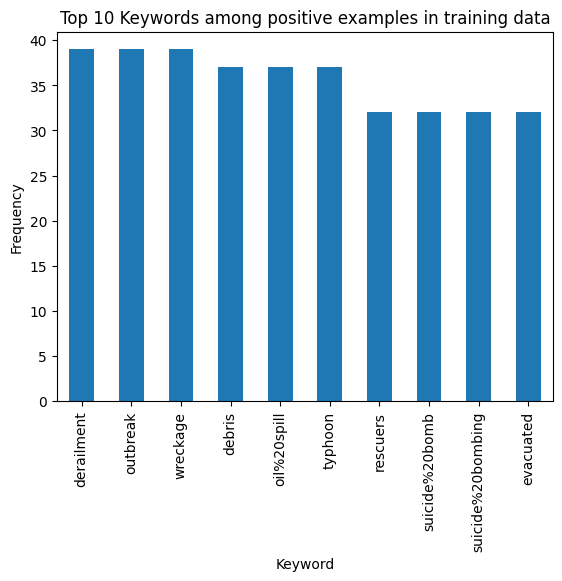

In [8]:
positive = df_train[df_train['target'] == 1]
topkeywords = positive['keyword'].value_counts()

topkeywords.head(10).plot(kind='bar')
plt.title('Top 10 Keywords among positive examples in training data')
plt.xlabel('Keyword')
plt.ylabel('Frequency')
plt.show()

Now we will preprocess the text, such as removing URLs (which may not be so relevant), and keeping the tweets to be lowercase etc. I will leave special characters like hashtag since it could give insight into the topic of the tweet. We use nltk to help us to remove stopwords and lemmatize.

In [9]:
import re

stopword = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(r'http\S+|www.\S+', '', text)

    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stopword]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    cleanedtext = ' '.join(tokens)

    return cleanedtext

In [10]:
df_train['cleanedtext'] = df_train['text'].apply(preprocess)

df_train.head()

,id,keyword,location,text,target,cleanedtext
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,deed reason # earthquake may allah forgive u
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask . canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,resident asked 'shelter place ' notified offic...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive # wildfire evacuation or..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo ruby # alaska smoke # wildfire ...


Now we can split our dataset for training.

In [11]:
X = df_train['cleanedtext']
y = df_train['target']

X_train, X_val, y_train, y_val = train_test_split(X, y,
    test_size=0.2,
    random_state=1108,
    stratify=y
)

**Training the Model**

Before feeding my text into the RNN model, I need to tokenize and pad.

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

alltext = df_train['cleanedtext'].tolist()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(alltext)
vocabsize = len(tokenizer.word_index) + 1

X_trainseq = tokenizer.texts_to_sequences(X_train)
X_valseq = tokenizer.texts_to_sequences(X_val)

X_trainpad = pad_sequences(X_trainseq, padding='post', maxlen=50)
X_valpad = pad_sequences(X_valseq, padding='post', maxlen=50)


In [13]:
#Parameters

embedding_dim = 64
max_length = 50

In [14]:
GRUmodel = Sequential([
    Embedding(input_dim=vocabsize, output_dim=embedding_dim, input_length=max_length),
    GRU(64),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

GRUmodel.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [15]:
GRUmodel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
history1 = GRUmodel.fit(
    X_trainpad,
    y_train,
    validation_data=(X_valpad, y_val),
    epochs=10,
    batch_size=64
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.5765 - loss: 0.6847 - val_accuracy: 0.5706 - val_loss: 0.6840
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5728 - loss: 0.6833 - val_accuracy: 0.5706 - val_loss: 0.6834
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5731 - loss: 0.6846 - val_accuracy: 0.5706 - val_loss: 0.6839
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5739 - loss: 0.6828 - val_accuracy: 0.5706 - val_loss: 0.6832
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5629 - loss: 0.6858 - val_accuracy: 0.5706 - val_loss: 0.6836
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5743 - loss: 0.6833 - val_accuracy: 0.5706 - val_loss: 0.6840
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5709 - loss: 0.6840 - val_accuracy: 0.5706 - val_loss: 0.6831
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5544 - loss: 0.6882 - val_accuracy: 0.5706 - val

The model doesn't seem to be doing too well, with an accuracy of less than 0.6. I adjusted parameters like the learning rate below, to see if it makes any difference.

In [17]:
GRUmodel2 = Sequential([
    Embedding(input_dim=vocabsize, output_dim=embedding_dim, input_length=max_length),
    GRU(64),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

GRUmodel2.compile(tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
history2 = GRUmodel2.fit(
    X_trainpad,
    y_train,
    validation_data=(X_valpad, y_val),
    epochs=10,
    batch_size=64
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.5608 - loss: 0.6923 - val_accuracy: 0.5706 - val_loss: 0.6843
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5596 - loss: 0.6872 - val_accuracy: 0.5706 - val_loss: 0.6838
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5708 - loss: 0.6852 - val_accuracy: 0.5706 - val_loss: 0.6837
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5696 - loss: 0.6848 - val_accuracy: 0.5706 - val_loss: 0.6833
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5662 - loss: 0.6845 - val_accuracy: 0.5706 - val_loss: 0.6834
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5754 - loss: 0.6823 - val_accuracy: 0.5706 - val_loss: 0.6832
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5657 - loss: 0.6847 - val_accuracy: 0.5706 - val_loss: 0.6832
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5611 - loss: 0.6861 - val_accuracy: 0.5706 - val_l

The GRU model does not seem to improve much even with adjustments of learning rates, and other hyperparameters. It doesn't seem to be learning much from the iterations and is stuck. Let's try to use LSTM instead.

In [26]:
LSTMmodel = Sequential([
    Embedding(input_dim=vocabsize, output_dim=embedding_dim, input_length=max_length),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

LSTMmodel.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [27]:
history3 = LSTMmodel.fit(
    X_trainpad,
    y_train,
    validation_data=(X_valpad, y_val),
    epochs=10,
    batch_size=64
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5569 - loss: 0.6863 - val_accuracy: 0.5706 - val_loss: 0.6846
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5714 - loss: 0.6836 - val_accuracy: 0.5706 - val_loss: 0.6838
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5599 - loss: 0.6858 - val_accuracy: 0.5706 - val_loss: 0.6832
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5741 - loss: 0.6828 - val_accuracy: 0.5706 - val_loss: 0.6835
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5708 - loss: 0.6846 - val_accuracy: 0.5706 - val_loss: 0.6834
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5705 - loss: 0.6833 - val_accuracy: 0.5706 - val_loss: 0.6832
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5712 - loss: 0.6832 - val_accuracy: 0.5706 - val_loss: 0.6834
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5646 - loss: 0.6853 - val_accuracy: 0.5706 - val

After using LSTM, I can see that I'm still stuck and my model is not training properly. I will try bidirectional LSTM. This might work better because bidirectional LSTM reads the sequence forward and backward, hence it is able to capture information from past and future context at every point, which is important in text.

In [28]:
LSTMmodel2 = Sequential([
    Embedding(input_dim=vocabsize, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

LSTMmodel2.compile(tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [29]:
history4 = LSTMmodel2.fit(
    X_trainpad,
    y_train,
    validation_data=(X_valpad, y_val),
    epochs=10,
    batch_size=64
)

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.6145 - loss: 0.6531 - val_accuracy: 0.7932 - val_loss: 0.4442
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8776 - loss: 0.3101 - val_accuracy: 0.7951 - val_loss: 0.4750
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9439 - loss: 0.1691 - val_accuracy: 0.7827 - val_loss: 0.5442
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9647 - loss: 0.1033 - val_accuracy: 0.7656 - val_loss: 0.6556
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9776 - loss: 0.0754 - val_accuracy: 0.7814 - val_loss: 0.7230
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9813 - loss: 0.0595 - val_accuracy: 0.7538 - val_loss: 0.7249
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9794 - loss: 0.0557 - val_accuracy: 0.7708 - val_loss: 0.7647
Epoch 8/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9821 - loss: 0.0491 - val_accuracy: 0.7689 - v

As expected, the bidirectional LSTM model now seems to work well for our training data, with the highest accuracy of 0.9828. Let's plot a figure for the validation loss and validation accuracy for our LSTM and bidirectional LSTM models.

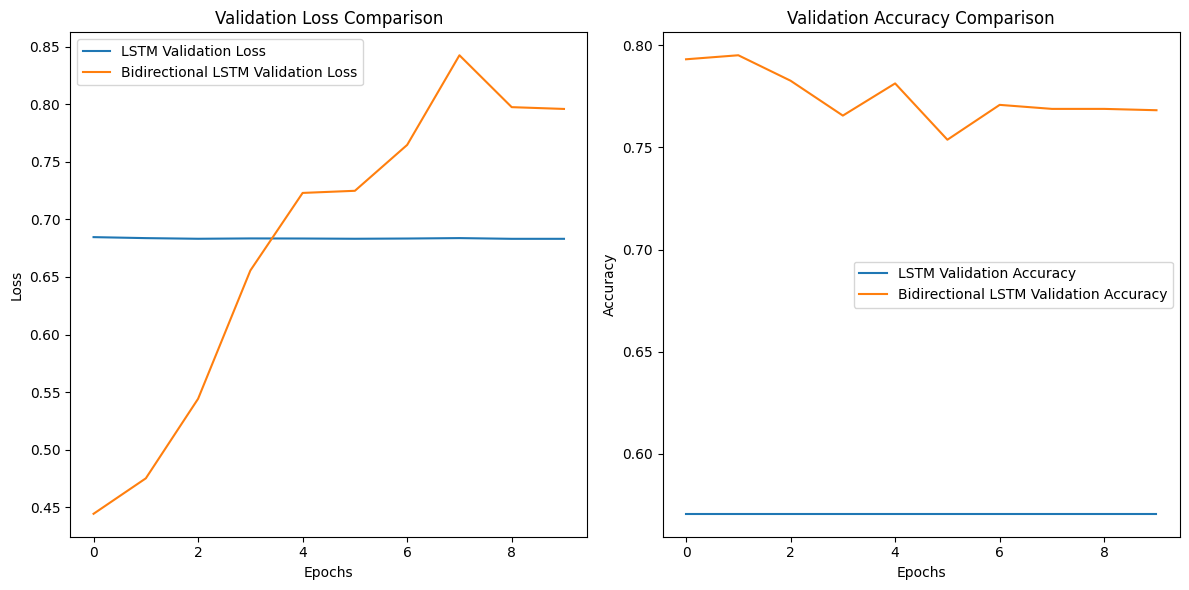

In [30]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history3.history['val_loss'], label='LSTM Validation Loss')
plt.plot(history4.history['val_loss'], label='Bidirectional LSTM Validation Loss')
plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history3.history['val_accuracy'], label='LSTM Validation Accuracy')
plt.plot(history4.history['val_accuracy'], label='Bidirectional LSTM Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Now that I have my model that I can use on my test data, let me examine the test dataset. Earlier I already imported the test dataset, which has 3,263 tweets.

In [31]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


Let's preprocess the text in the test dataframe too, before we can use our model to predict the target.

In [32]:
df_test['cleanedtext'] = df_test['text'].apply(preprocess)
X_test = df_test['cleanedtext']

X_testseq = tokenizer.texts_to_sequences(X_test)
X_testpad = pad_sequences(X_testseq, padding='post', maxlen=50)

We then make predictions with our bidirectional LSTM model.

In [33]:
y_predprob = LSTMmodel2.predict(X_testpad)
y_pred = (y_predprob > 0.5).astype(int)

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [34]:
df_test['target'] = y_pred

df_submission = df_test[['id', 'target']]




Let's just take a look at our test data. The first text for example, was correctly identified to not be about real disasters, it was a car crash.

In [37]:
df_test.head()

,id,keyword,location,text,cleanedtext,target
0,0,NaN,NaN,Just happened a terrible car crash,happened terrible car crash,0
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...","heard # earthquake different city , stay safe ...",0
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","forest fire spot pond , goose fleeing across s...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting . # spokane # wildfire,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill 28 china taiwan,1


In [35]:
df_submission.to_csv('submissions.csv', index=False)

**Conclusion**

For the purpose of predicting what category the text is about, it is important to understand the full context of the text, which would require bidirectional models. I found that the normal GRU and LSTM models got stuck when training my models, and produced not so optimal accuracy, as compared to my bidirectional LSTM.

If I could improve my prediction score, I would also look into adjusting other parameters like my dropout, as there seemed to be some early signs of overfitting in my bidirectional LSTM model. It would also be interesting to go back to see if a bidirectional GRU model would be better and how it would compare to a bidirectional LSTM model.

Lastly, I preprocessed my text by removing stopwords. In hindsight, I would like to see if the model could be improved if I had just used the input text without any preprocessing, as some stopwards could change the meaning of the text. In future, this would be one improvement to make, given the importance of context for understanding the meaning of some body of text.

**Resources**

I referred to nltk documentation on the preprocessing of my text, as well as the regex on removing links (https://regex101.com/r/hG9t0Q/1).

This Medium article (https://medium.com/codex/natural-language-processing-cleaning-up-tweets-2b71793e91b5) also provided an example of the data cleaning process which I read through and got some inspiration from, although it was much more complex than what we have learnt, so I did not end up using it.


Link to my github repo: https://github.com/homelyiiiii/DSTA5511-Week-4